In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path


In [2]:
fig_output_dir_p1 = "./figures/p1"
os.makedirs(fig_output_dir_p1, exist_ok=True)

current_dir = Path.cwd()

data_dir = current_dir.parent / "data"
data_dir = data_dir.resolve() 


In [3]:
from preprocessing.data_loader import DataLoader, DatasetConfig, SplitConfig

# Punto 1

## Punto 1.1

#### Inicialización de la configuración del dataset

In [4]:
data_dir_p1 = data_dir / "p1"

config_cell_diagnosis = DatasetConfig(
        data_dir=data_dir_p1,
        target_column="Diagnosis",
        split_config=SplitConfig(test_size=0.2, shuffle=True, random_state=42)
    )

loader_cell_diagnosis = DataLoader(config_cell_diagnosis)

loader_cell_diagnosis.load_data(
        dev_file="raw/cell_diagnosis_balanced_dev.csv",
        test_file='raw/cell_diagnosis_balanced_test.csv',
        splitted=False
    )


cell_diagnosis_balanced_dev_outliers, cell_diagnosis_balanced_test_outliers = loader_cell_diagnosis.get_pandas_data(splitted=False)



Se busca si hay features que tengan valores nulos

In [5]:
def analyze_null_values(dataframes, dataset_names=None):
    """
    Analiza y muestra información detallada sobre valores nulos en uno o más DataFrames.
    
    Parameters
    ----------
    dataframes : list or pd.DataFrame
        Un DataFrame o lista de DataFrames para analizar
    dataset_names : list, optional
        Lista de nombres para identificar cada DataFrame. Si es None, se usarán nombres genéricos.
        
    Returns
    -------
    dict
        Diccionario con los resultados del análisis para cada DataFrame
    """
    from IPython.display import display, HTML
    import pandas as pd
    
    # Convertir entrada única a lista para procesamiento uniforme
    if not isinstance(dataframes, list):
        dataframes = [dataframes]
    
    # Generar nombres por defecto si no se proporcionan
    if dataset_names is None:
        dataset_names = [f"Dataset {i+1}" for i in range(len(dataframes))]
    elif len(dataset_names) != len(dataframes):
        dataset_names = [f"Dataset {i+1}" for i in range(len(dataframes))]
    
    results = {}
    
    for df, name in zip(dataframes, dataset_names):
        print(f"Valores nulos en {name}:")
        
        # Análisis de valores nulos por columna
        null_counts = df.isnull().sum()
        total_rows = len(df)
        null_percentage = (null_counts / total_rows) * 100
        
        # Crear DataFrame para mostrar como tabla
        null_table = pd.DataFrame({
            'Columna': null_counts.index,
            'Cantidad de nulos': null_counts.values,
            'Porcentaje (%)': null_percentage.values.round(2)
        })
        display(null_table)
        
        # Información de muestras con valores nulos
        samples_with_nulls = df.isnull().any(axis=1).sum()
        samples_without_nulls = total_rows - samples_with_nulls
        samples_percentage = (samples_with_nulls / total_rows) * 100
        
        summary = pd.DataFrame({
            'Métrica': ['Muestras con al menos un valor nulo', 'Muestras sin valores nulos', 'Total de muestras'],
            'Cantidad': [samples_with_nulls, samples_without_nulls, total_rows],
            'Porcentaje (%)': [samples_percentage.round(2), (100-samples_percentage).round(2), 100.0]
        })
        display(summary)
        
        # Guardar resultados
        results[name] = {
            'null_table': null_table,
            'summary': summary,
            'total_nulls': null_counts.sum(),
            'total_rows': total_rows,
            'null_percentage': (null_counts.sum() / (total_rows * len(df.columns)) * 100).round(2)
        }
        
        print("\n")
    
    return results

# Analizar valores nulos en ambos conjuntos de datos
analyze_null_values(
    [cell_diagnosis_balanced_dev_outliers, cell_diagnosis_balanced_test_outliers],
    ["conjunto de desarrollo", "conjunto de prueba"]
);


Valores nulos en conjunto de desarrollo:


,Columna,Cantidad de nulos,Porcentaje (%)
0,CellSize,330,19.84
1,CellShape,316,19.00
2,NucleusDensity,301,18.10
3,ChromatinTexture,297,17.86
4,CytoplasmSize,316,19.00
5,CellAdhesion,294,17.68
6,MitosisRate,320,19.24
7,NuclearMembrane,320,19.24
8,GrowthFactor,304,18.28
9,OxygenSaturation,288,17.32


,Métrica,Cantidad,Porcentaje (%)
0,Muestras con al menos un valor nulo,1538,92.48
1,Muestras sin valores nulos,125,7.52
2,Total de muestras,1663,100.00




Valores nulos en conjunto de prueba:


,Columna,Cantidad de nulos,Porcentaje (%)
0,CellSize,35,18.92
1,CellShape,41,22.16
2,NucleusDensity,32,17.30
3,ChromatinTexture,35,18.92
4,CytoplasmSize,33,17.84
5,CellAdhesion,29,15.68
6,MitosisRate,36,19.46
7,NuclearMembrane,25,13.51
8,GrowthFactor,40,21.62
9,OxygenSaturation,31,16.76


,Métrica,Cantidad,Porcentaje (%)
0,Muestras con al menos un valor nulo,172,92.97
1,Muestras sin valores nulos,13,7.03
2,Total de muestras,185,100.00


In [6]:
from preprocessing.imputation import KNNImputer
custom_imputer = KNNImputer(n_neighbors=8, weights='distance',return_df=True)


In [7]:
def train_valid_split(df, test_size=0.2, random_state=42):
    """
    Split a DataFrame into training and validation sets.
    
    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame to split
    test_size : float, default=0.2
        The proportion of the dataset to include in the validation split
    random_state : int, default=42
        Controls the shuffling applied to the data before applying the split
        
    Returns
    -------
    tuple
        (train_df, valid_df) - The split DataFrames
    """
    np.random.seed(random_state)
    shuffled_indices = np.random.permutation(len(df))
    test_set_size = int(len(df) * test_size)
    valid_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return df.iloc[train_indices], df.iloc[valid_indices]


def impute_missing_values(train_df, valid_df=None, test_df=None, knn_neighbors=8, knn_weights='distance'):
    """
    Impute missing values in datasets using a two-step approach:
    1. First impute with mean/mode from training data
    2. Then refine with KNN imputation
    
    Parameters
    ----------
    train_df : pd.DataFrame
        Training dataset
    valid_df : pd.DataFrame, optional
        Validation dataset
    test_df : pd.DataFrame, optional
        Test dataset
    knn_neighbors : int, default=8
        Number of neighbors to use for KNN imputation
    knn_weights : str, default='distance'
        Weight function used in prediction by KNN imputation
        
    Returns
    -------
    tuple
        Tuple containing the imputed DataFrames in the same order as provided
    """
    # Reset indices for all dataframes
    train_df = train_df.reset_index(drop=True)
    if valid_df is not None:
        valid_df = valid_df.reset_index(drop=True)
    if test_df is not None:
        test_df = test_df.reset_index(drop=True)
    
    # Print information about missing values before imputation
    print("Missing values before imputation:")
    print(f"Train: {train_df.isna().sum().sum()} missing values")
    if valid_df is not None:
        print(f"Valid: {valid_df.isna().sum().sum()} missing values")
    if test_df is not None:
        print(f"Test: {test_df.isna().sum().sum()} missing values")
    

    
    # Step 2: Apply KNN imputation to refine the results
    custom_imputer = KNNImputer(n_neighbors=knn_neighbors, weights=knn_weights, return_df=True)
    custom_imputer.fit(train_df)
    
    # Transform all datasets
    imputed_train = custom_imputer.transform(train_df)
    imputed_valid = custom_imputer.transform(valid_df) if valid_df is not None else None
    imputed_test = custom_imputer.transform(test_df) if test_df is not None else None
    
    # Print information about missing values after imputation
    print("\nMissing values after imputation:")
    print(f"Train: {imputed_train.isna().sum().sum()} missing values")
    if imputed_valid is not None:
        print(f"Valid: {imputed_valid.isna().sum().sum()} missing values")
    if imputed_test is not None:
        print(f"Test: {imputed_test.isna().sum().sum()} missing values")
    
    # Return imputed datasets in the same order they were provided
    result = [imputed_train]
    if valid_df is not None:
        result.append(imputed_valid)
    if test_df is not None:
        result.append(imputed_test)
    
    return tuple(result) if len(result) > 1 else result[0]




In [8]:

cell_diagnosis_balanced_train_outliers, cell_diagnosis_balanced_valid_outliers = train_valid_split(
    cell_diagnosis_balanced_dev_outliers, test_size=0.2, random_state=12
)


# Apply the imputation process
cell_diagnosis_balanced_train_outliers, cell_diagnosis_balanced_valid_outliers, cell_diagnosis_balanced_test_outliers = impute_missing_values(
    cell_diagnosis_balanced_train_outliers,
    cell_diagnosis_balanced_valid_outliers,
    cell_diagnosis_balanced_test_outliers,
    knn_neighbors=8,
    knn_weights='distance'
)

Missing values before imputation:
Train: 3142 missing values
Valid: 821 missing values
Test: 444 missing values

Missing values after imputation:
Train: 0 missing values
Valid: 0 missing values
Test: 0 missing values


Si ya se realizó el preprocesamiento, comentar el siguiente codigo

In [9]:


loader_cell_diagnosis.update(df_train=cell_diagnosis_balanced_train_outliers, df_valid=cell_diagnosis_balanced_valid_outliers, df_test=cell_diagnosis_balanced_test_outliers)


df_preprocessed_cell_diagnosis_test_dir = data_dir / "p1" / "preprocessed" / "cell_diagnosis_balanced_test.csv"
df_preprocessed_cell_diagnosis_train_dir = data_dir / "p1" / "preprocessed" / "cell_diagnosis_balanced_train.csv"
df_preprocessed_cell_diagnosis_valid_dir = data_dir / "p1" / "preprocessed" / "cell_diagnosis_balanced_valid.csv"

loader_cell_diagnosis.save_processed_data(df_train_dir=df_preprocessed_cell_diagnosis_train_dir, df_valid_dir=df_preprocessed_cell_diagnosis_valid_dir, df_test_dir=df_preprocessed_cell_diagnosis_test_dir)

Training data saved to /Users/juanfra/Documents/Facultad/3er año - 1er Cuatri/Aprendizaje Automatico/TPs/tp2-machine-learning /data/p1/preprocessed/cell_diagnosis_balanced_train.csv
Validation data saved to /Users/juanfra/Documents/Facultad/3er año - 1er Cuatri/Aprendizaje Automatico/TPs/tp2-machine-learning /data/p1/preprocessed/cell_diagnosis_balanced_valid.csv
Test data saved to /Users/juanfra/Documents/Facultad/3er año - 1er Cuatri/Aprendizaje Automatico/TPs/tp2-machine-learning /data/p1/preprocessed/cell_diagnosis_balanced_test.csv


In [10]:

loader_cell_diagnosis.load_data(
        train_file="preprocessed/cell_diagnosis_balanced_train.csv",
        valid_file='preprocessed/cell_diagnosis_balanced_valid.csv',
        test_file='preprocessed/cell_diagnosis_balanced_test.csv',
        splitted=True
    )



cell_diagnosis_balanced_train_outliers, cell_diagnosis_balanced_valid_outliers, cell_diagnosis_balanced_test_outliers = loader_cell_diagnosis.get_pandas_data(splitted=True)


In [11]:
from utils.utils import print_numerical_features_range

In [12]:

print_numerical_features_range(cell_diagnosis_balanced_valid_outliers);



Rango de cada feature numérica (13 features):


Feature,Mínimo,Máximo
CellSize,-100.0000,1000.0000
CellShape,-0.9033,5.0486
NucleusDensity,-3.0000,50.0000
ChromatinTexture,10.0000,263.7934
CytoplasmSize,10.3083,277.5190
CellAdhesion,-0.5715,4.4607
MitosisRate,-5.0000,60.0000
NuclearMembrane,-3.4390,22.0818
GrowthFactor,-50.0000,557.9438
OxygenSaturation,-10.0000,757.3417


Se analiza el conjunto de dev completamente
No es necesario hacer esto con el test

In [13]:
from utils.visuals import (analyze_categorical_variables, analyze_target_distribution,
                          plot_numerical_distributions, plot_correlation_heatmap
                          )



exclude_columns = ["Diagnosis"]
numerical_cols = cell_diagnosis_balanced_valid_outliers.select_dtypes(include=['number']).columns.tolist()

numerical_cols = [col for col in numerical_cols if col not in exclude_columns]


analyze_categorical_variables(cell_diagnosis_balanced_valid_outliers, ["CellType", "GeneticMutation"]);


Categorical variables distribution:

CellType distribution:


,CellType,Count
0,???,142
1,Epthlial,111
2,Mesnchymal,79


CellType distribution percentage:


,CellType,Percentage (%)
0,???,42.77
1,Epthlial,33.43
2,Mesnchymal,23.80



GeneticMutation distribution:


,GeneticMutation,Count
0,Absnt,174
1,Presnt,158


GeneticMutation distribution percentage:


,GeneticMutation,Percentage (%)
0,Absnt,52.41
1,Presnt,47.59


In [14]:

analyze_target_distribution(cell_diagnosis_balanced_valid_outliers, "Diagnosis");


Target (Diagnosis) distribution:


Diagnosis,Count
0.0,176
1.0,156



Target (Diagnosis) distribution percentage:


Diagnosis,Percentage (%)
0.0,53.01
1.0,46.99


In [15]:
ALL_FEATURES = cell_diagnosis_balanced_dev_outliers.columns.tolist()
FEATURES_TO_PLOT = ['CellSize', 'MitosisRate', 'NucleusDensity']


Saved figure to figures/numerical_distributions_outliers.png


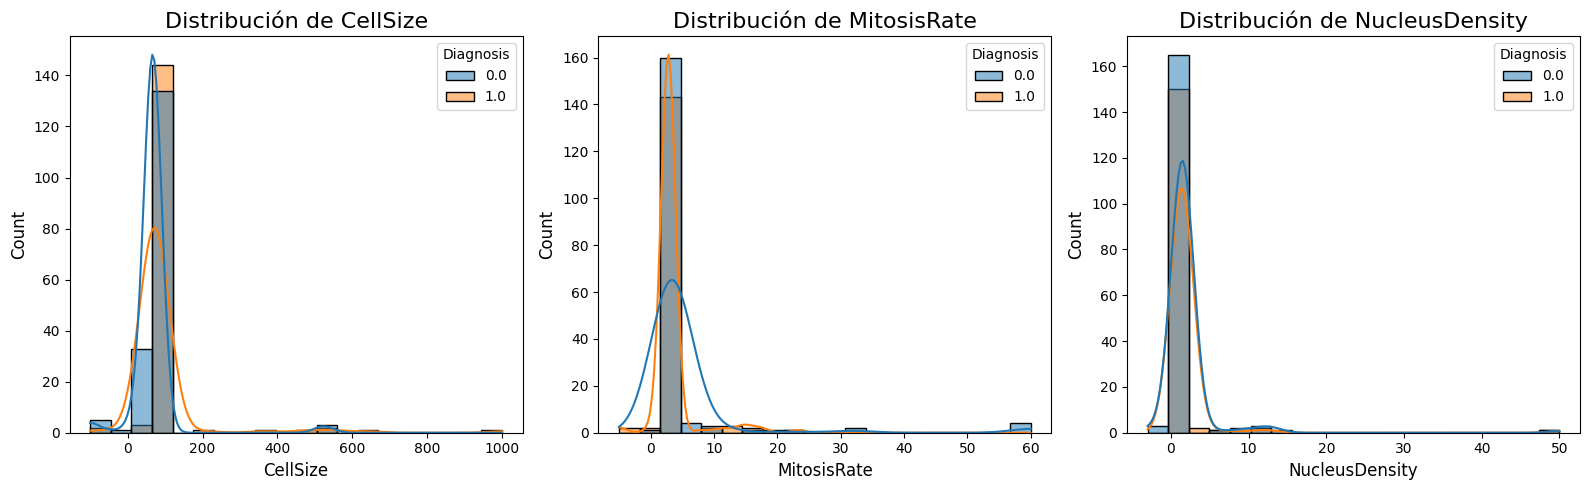

In [16]:

fig = plot_numerical_distributions(cell_diagnosis_balanced_valid_outliers, numerical_cols, "Diagnosis",features_to_plot=FEATURES_TO_PLOT,figsize=(16,5),output_dir="figures",filename="numerical_distributions_outliers.png")
plt.show()

Saved figure to ./figures/p1/correlation_heatmap_numerical_features_outliers.png


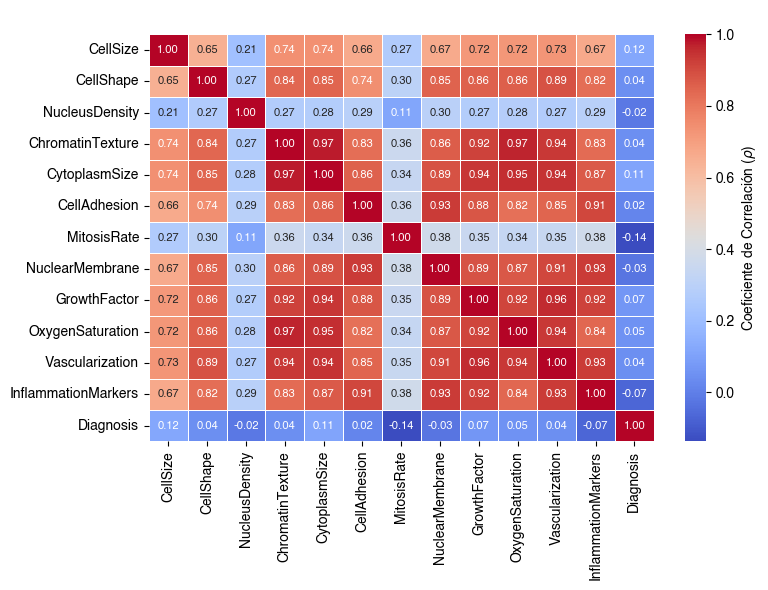

In [17]:

fig = plot_correlation_heatmap(
    cell_diagnosis_balanced_valid_outliers, 
    numerical_cols + ["Diagnosis"],
    output_dir=fig_output_dir_p1,
    filename="correlation_heatmap_numerical_features_outliers.png",
    title=' ',
    figsize=(8,6),
)
plt.show()


Observamos que hay muchos outliers

Gráfico guardado en: ./figures/p1/boxplots_outliers_analysis.png


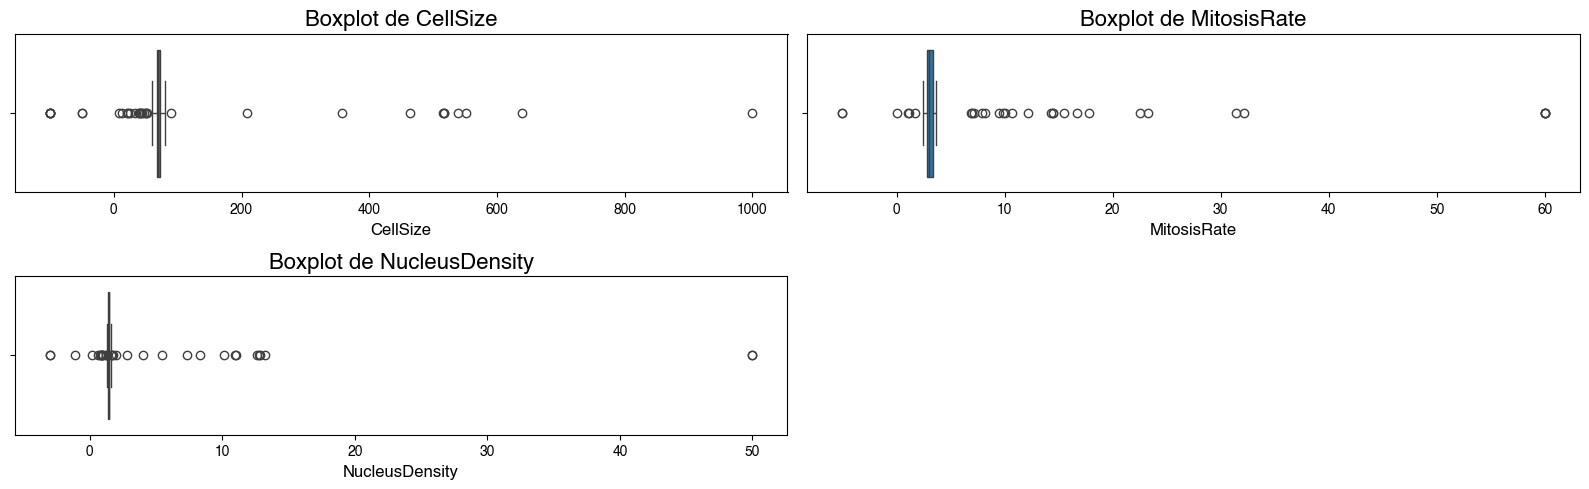

In [18]:
from utils.visuals import plot_outliers_analysis


fig = plot_outliers_analysis(
    df=cell_diagnosis_balanced_valid_outliers, 
    features_to_plot=FEATURES_TO_PLOT,
    save_dir=fig_output_dir_p1,
    filename='boxplots_outliers_analysis.png',
    figsize=(16, 5),
    show_plots=True
)


In [ ]:
from preprocessing.outliers import replace_outliers_iqr

Si ya se realizó el preprocesamiento, comentar el siguiente codigo

In [20]:
cell_diagnosis_balanced_train, params = replace_outliers_iqr(cell_diagnosis_balanced_train_outliers, method='winsorize', return_params=True)
cell_diagnosis_balanced_valid = replace_outliers_iqr(cell_diagnosis_balanced_valid_outliers, method='winsorize', params=params)
cell_diagnosis_balanced_test = replace_outliers_iqr(cell_diagnosis_balanced_test_outliers, method='winsorize', params=params)

cell_diagnosis_balanced_dev = pd.concat([cell_diagnosis_balanced_train, cell_diagnosis_balanced_valid])


loader_cell_diagnosis.update(
    df_train=cell_diagnosis_balanced_train,
    df_valid=cell_diagnosis_balanced_valid,
    df_test=cell_diagnosis_balanced_test
)

df_cell_diagnosis_train_dir = data_dir / "p1" / "processed" / "cell_diagnosis_balanced_train.csv"
df_cell_diagnosis_valid_dir = data_dir / "p1" / "processed" / "cell_diagnosis_balanced_valid.csv"
df_cell_diagnosis_test_dir = data_dir / "p1" / "processed" / "cell_diagnosis_balanced_test.csv"
df_cell_diagnosis_dev_dir = data_dir / "p1" / "processed" / "cell_diagnosis_balanced_dev.csv"

pd.DataFrame(cell_diagnosis_balanced_dev).to_csv(df_cell_diagnosis_dev_dir, index=False)

loader_cell_diagnosis.save_processed_data(
    df_train_dir=df_cell_diagnosis_train_dir,
    df_valid_dir=df_cell_diagnosis_valid_dir,
    df_test_dir=df_cell_diagnosis_test_dir,
    df_dev_dir=df_cell_diagnosis_dev_dir
)



Training data saved to /Users/juanfra/Documents/Facultad/3er año - 1er Cuatri/Aprendizaje Automatico/TPs/tp2-machine-learning /data/p1/processed/cell_diagnosis_balanced_train.csv
Validation data saved to /Users/juanfra/Documents/Facultad/3er año - 1er Cuatri/Aprendizaje Automatico/TPs/tp2-machine-learning /data/p1/processed/cell_diagnosis_balanced_valid.csv
Test data saved to /Users/juanfra/Documents/Facultad/3er año - 1er Cuatri/Aprendizaje Automatico/TPs/tp2-machine-learning /data/p1/processed/cell_diagnosis_balanced_test.csv
Development data saved to /Users/juanfra/Documents/Facultad/3er año - 1er Cuatri/Aprendizaje Automatico/TPs/tp2-machine-learning /data/p1/processed/cell_diagnosis_balanced_dev.csv


In [21]:

loader_cell_diagnosis.load_data(
    train_file="processed/cell_diagnosis_balanced_train.csv",
    valid_file='processed/cell_diagnosis_balanced_valid.csv',
    test_file='processed/cell_diagnosis_balanced_test.csv',
    splitted=True
)

cell_diagnosis_balanced_train, cell_diagnosis_balanced_valid, cell_diagnosis_balanced_test = loader_cell_diagnosis.get_pandas_data(splitted=True)


In [22]:

print_numerical_features_range(cell_diagnosis_balanced_valid);


Rango de cada feature numérica (13 features):


Feature,Mínimo,Máximo
CellSize,57.6812,81.5172
CellShape,0.4285,0.5739
NucleusDensity,1.2642,1.6212
ChromatinTexture,19.3019,24.8079
CytoplasmSize,20.4988,36.3413
CellAdhesion,0.4116,0.5412
MitosisRate,1.8389,4.3878
NuclearMembrane,1.8528,2.9358
GrowthFactor,50.5599,70.3781
OxygenSaturation,76.5477,83.6431


Saved figure to figures/numerical_distributions.png


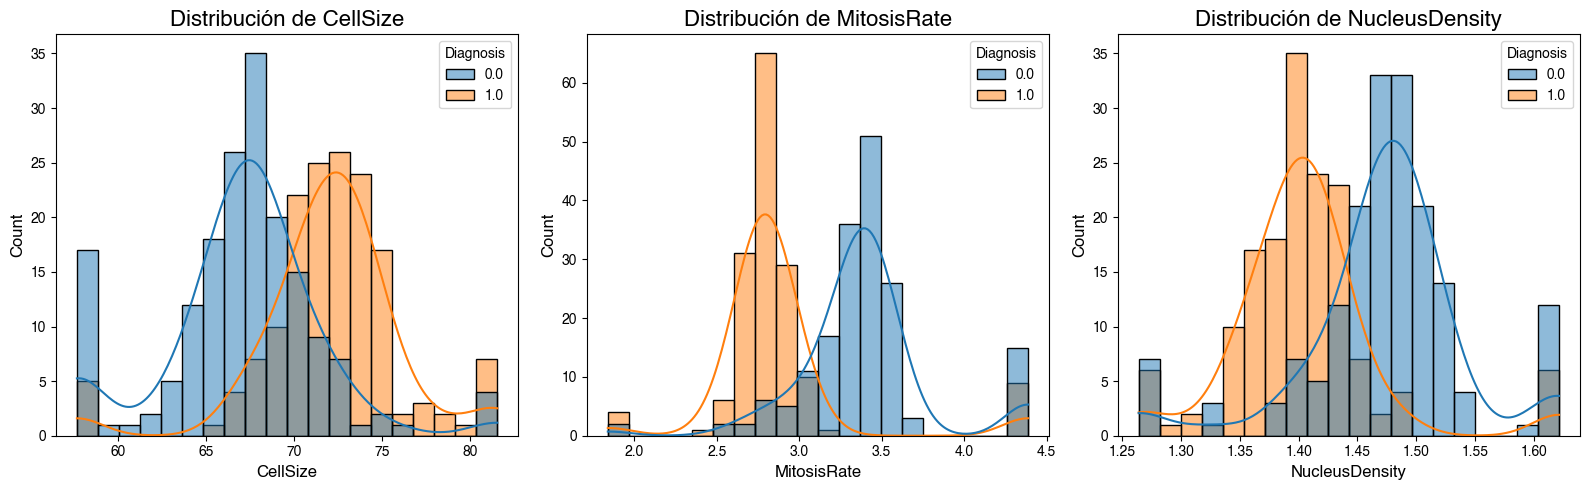

In [23]:

fig = plot_numerical_distributions(
    cell_diagnosis_balanced_valid, 
    numerical_cols=cell_diagnosis_balanced_valid.select_dtypes(include=['number']).columns,
    features_to_plot=FEATURES_TO_PLOT,
    target_column="Diagnosis",
    output_dir='figures',
    filename='numerical_distributions.png',
    figsize=(16, 5)
)

plt.show()

Saved figure to ./figures/p1/correlation_heatmap_numerical_features.png


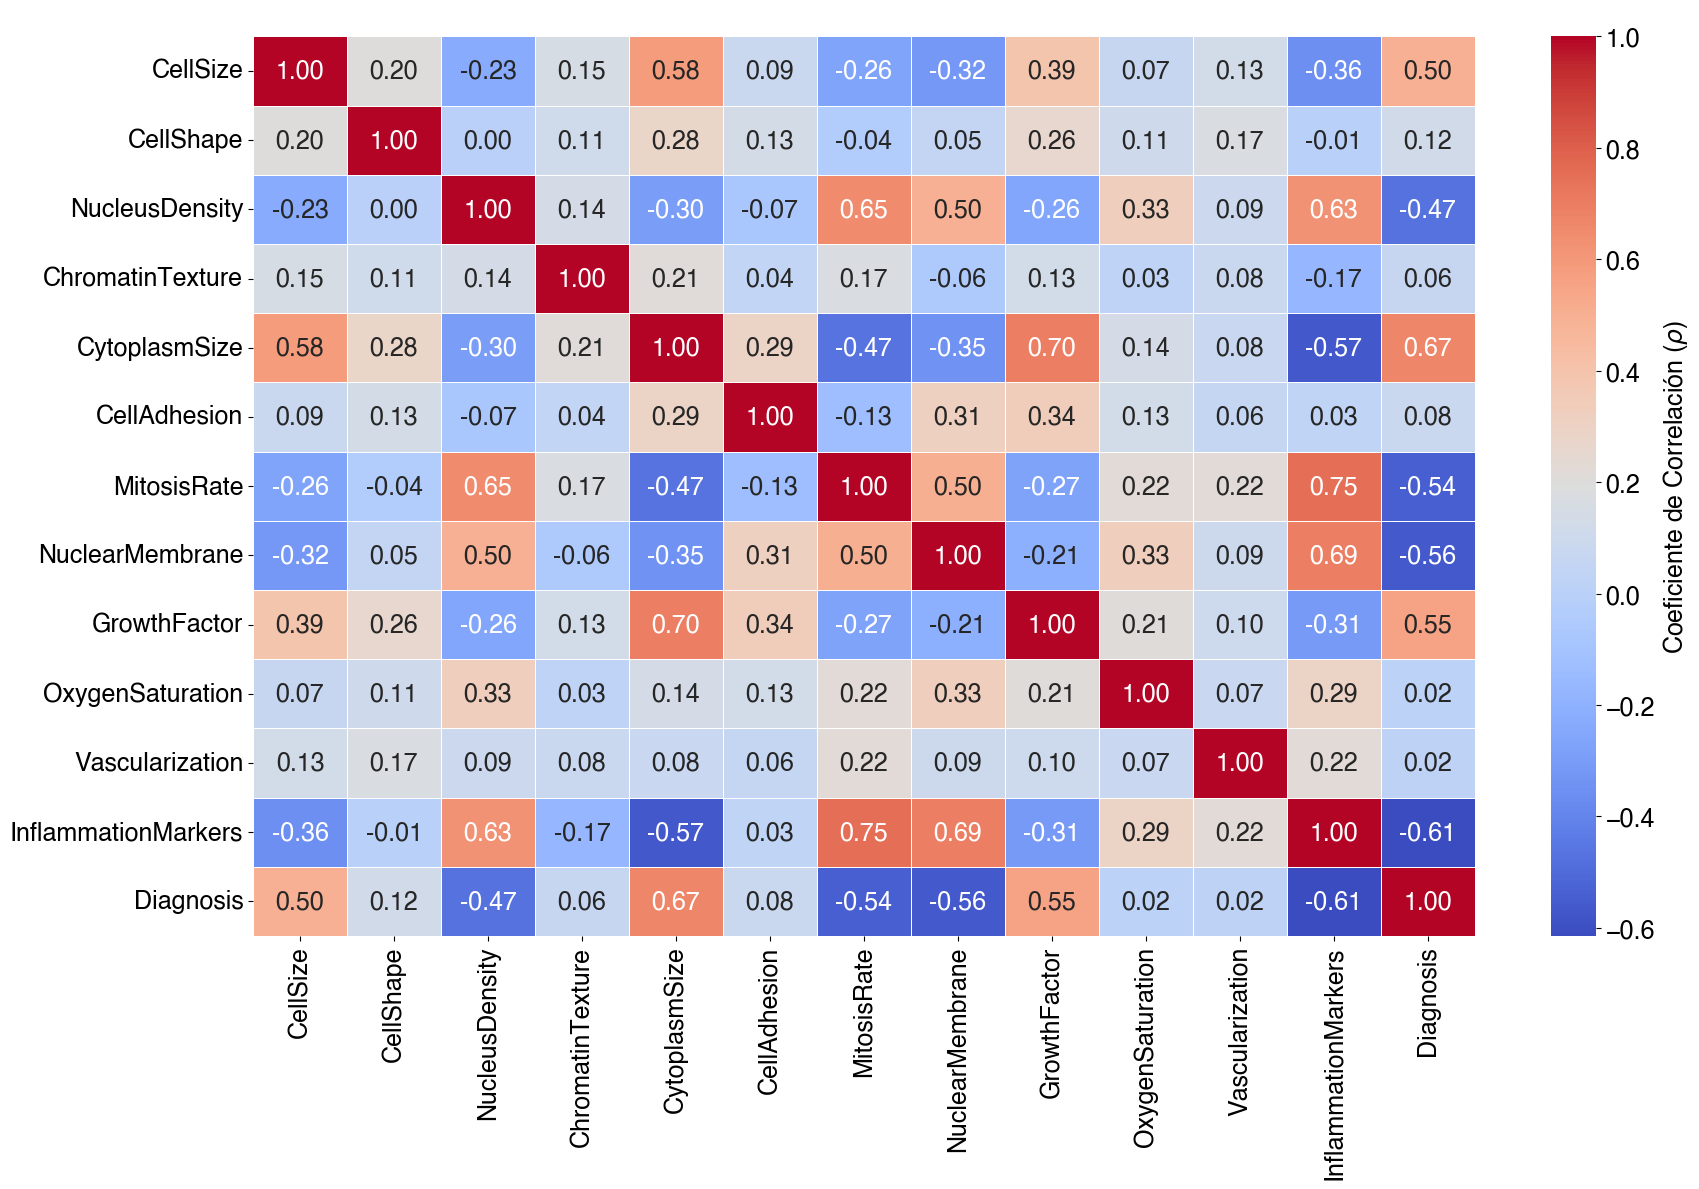

In [24]:

fig = plot_correlation_heatmap(
    cell_diagnosis_balanced_valid, 
    numerical_cols + ["Diagnosis"],
    output_dir=fig_output_dir_p1,
    filename="correlation_heatmap_numerical_features.png",
    title=' ',
    label_fontsize=18,
    title_fontsize=18,
    tick_fontsize=18,
    cbar_fontsize=18,
    annot_fontsize=18,
    figsize=(18,12),
)
plt.show()



Son correlaciones bastantes altas considerando que el set de datos es pequeño (valid)

Gráfico guardado en: ./figures/p1/boxplots_analysis.png


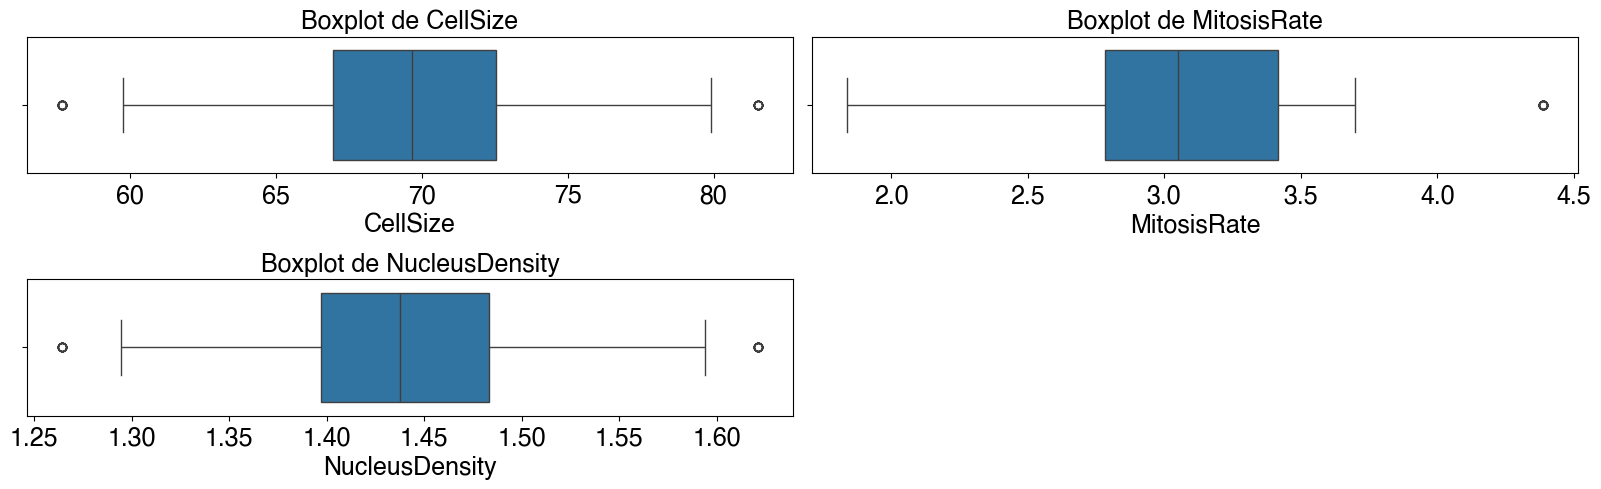

In [25]:

from utils.visuals import plot_outliers_analysis


fig = plot_outliers_analysis(
    df=cell_diagnosis_balanced_valid, 
    features_to_plot=FEATURES_TO_PLOT,
    save_dir=fig_output_dir_p1,
    figsize=(16, 5),
    filename='boxplots_analysis.png',
    show_plots=True
)


## Punto 1.2

In [26]:
from models.logistic_regression import LogisticRegression, LogisticRegressionConfig

In [27]:
from evaluation.cross_validation import cross_validate_lambda
from evaluation.metrics import f1_score, recall_score 
from utils.visuals import plot_lambda_tuning
import numpy as np


In [28]:
import pandas as pd

def apply_feature_engineering(df, transformations, inplace=False, verbose=False):
    """
    Aplica transformaciones de feature engineering a un DataFrame.
    
    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame de entrada.
    transformations : dict
        Diccionario en el que cada clave es el nombre de la nueva feature y cada valor es una función 
        que recibe el DataFrame y retorna una pd.Series con los valores de la nueva feature.
        Ejemplo:
            {
                "CellSize_Cytoplasm_Ratio": lambda d: d["CellSize"] / d["CytoplasmSize"],
                "LogInflammation": lambda d: np.log1p(d["InflammationMarkers"])
            }
    inplace : bool, default=False
        Si es True, se modifica el DataFrame original; de lo contrario se trabaja sobre una copia.
    verbose : bool, default=False
        Si es True, imprime información sobre cada transformación aplicada.
        
    Retorna
    -------
    pd.DataFrame
        DataFrame con las nuevas features añadidas.
    """
    if not inplace:
        df = df.copy()
        
    for new_feature, transform_func in transformations.items():
        if verbose:
            print(f"Aplicando transformación para la feature: '{new_feature}'")
        try:
            df[new_feature] = transform_func(df)
        except Exception as e:
            raise e
    return df

In [29]:


# Definir transformaciones básicas
transformations = {
    "Nucleus_Cytoplasm_Ratio": lambda d: (d["CellSize"] - d["CytoplasmSize"]) / d["CytoplasmSize"],
    "ProliferationIndex": lambda d: d["GrowthFactor"] * d["MitosisRate"],
    "DensityTextureIndex": lambda d: d["NucleusDensity"] * d["ChromatinTexture"],
}


# Aplicar las transformaciones de feature engineering
cell_diagnosis_balanced_train = apply_feature_engineering(cell_diagnosis_balanced_train, transformations, verbose=False)
cell_diagnosis_balanced_valid = apply_feature_engineering(cell_diagnosis_balanced_valid, transformations, verbose=False)
cell_diagnosis_balanced_test = apply_feature_engineering(cell_diagnosis_balanced_test, transformations, verbose=False)


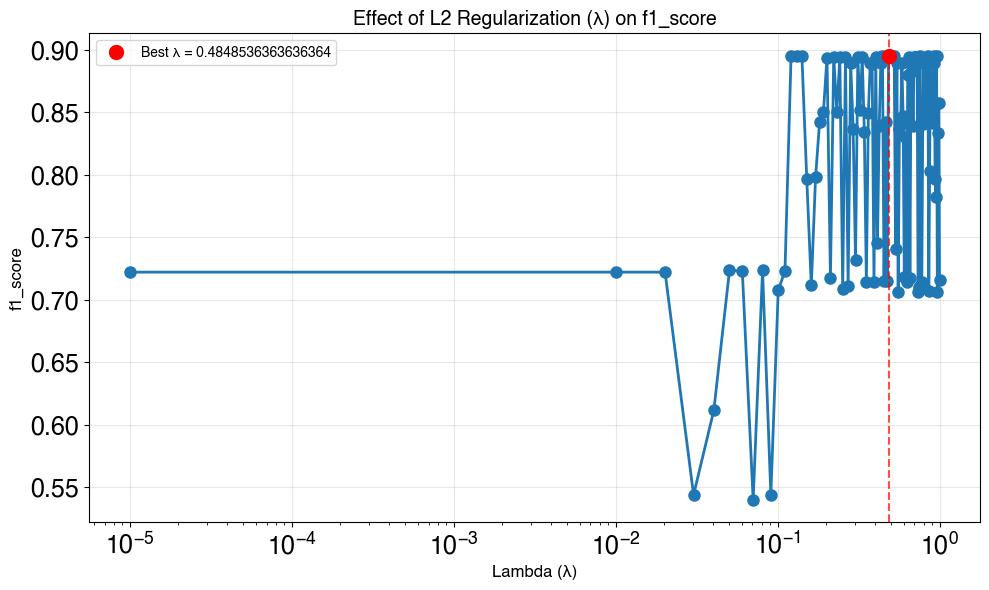

In [30]:
from evaluation.cross_validation import stratified_cross_validate_lambda


X_train_cell_diagnosis, y_train_cell_diagnosis = cell_diagnosis_balanced_train.drop(columns=["Diagnosis"]), cell_diagnosis_balanced_train["Diagnosis"]

X_train_cell_diagnosis = DataLoader.encode_categorical(X_train_cell_diagnosis)
X_train_cell_diagnosis, y_train_cell_diagnosis = X_train_cell_diagnosis.to_numpy(), y_train_cell_diagnosis.to_numpy()

lambda_values = np.linspace(0.00001, 1, 100)


best_lambda, mean_scores = cross_validate_lambda(
    X=X_train_cell_diagnosis,
    y=y_train_cell_diagnosis,
    lambda_values=lambda_values,
    metric_fn=f1_score,
    k_folds=5,
    verbose=False,
    threshold=0.2
)

# Plot results manually
plot_lambda_tuning(
    lambda_values=lambda_values,
    scores=mean_scores,
    metric_name=f1_score.__name__,
    best_lambda=best_lambda
)

In [31]:

print(f"Optimal lambda value: {best_lambda}")


final_config = LogisticRegressionConfig(
    learning_rate=0.01,
    max_iter=1000,
    tol=1e-4,
    lambda_reg=best_lambda
)


Optimal lambda value: 0.4848536363636364


In [32]:
from utils.utils import evaluate_model

Saved confusion matrix to ./figures/p1/test_balanced_confusion_matrix.png


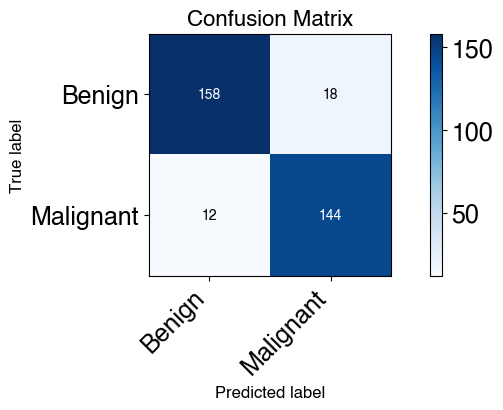

Saved ROC curve to ./figures/p1/test_balanced_roc_curve.png


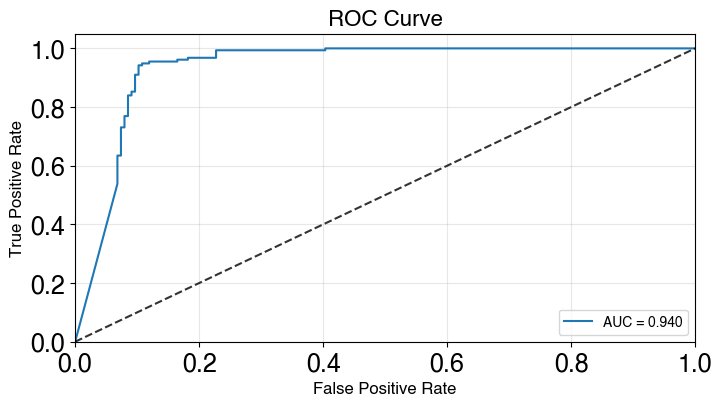

Saved precision-recall curve to ./figures/p1/test_balanced_precision_recall_curve.png


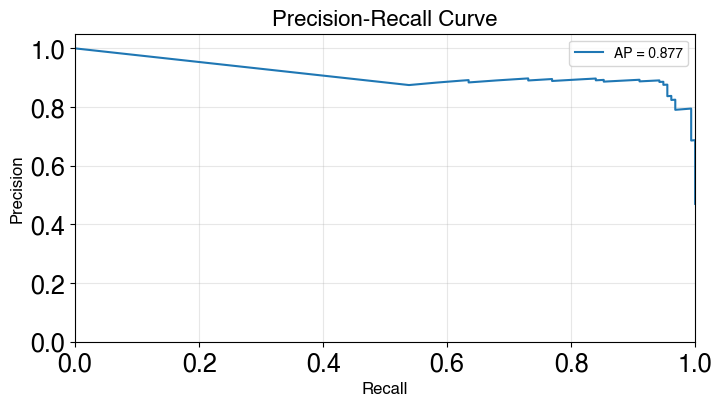


Model Evaluation Metrics:
Confusion Matrix:
[[158  18]
 [ 12 144]]
Accuracy: 0.9096
Precision: 0.8889
Recall: 0.9231
F1 Score: 0.9057
AUC-ROC: 0.9399
AUC-PR: 0.8774


In [33]:

X_valid_cell_diagnosis, y_valid_cell_diagnosis = cell_diagnosis_balanced_valid.drop(columns=["Diagnosis"]), cell_diagnosis_balanced_valid["Diagnosis"]

X_valid_cell_diagnosis = DataLoader.encode_categorical(X_valid_cell_diagnosis)
X_valid_cell_diagnosis, y_valid_cell_diagnosis = X_valid_cell_diagnosis.to_numpy(), y_valid_cell_diagnosis.to_numpy()

final_model = LogisticRegression(final_config)

final_model.fit(X_train_cell_diagnosis, y_train_cell_diagnosis)


results = evaluate_model(
    threshold=0.2,
    model=final_model, 
    X_test=X_valid_cell_diagnosis, 
    y_test=y_valid_cell_diagnosis, 
    class_names=["Benign", "Malignant"],
    save_dir=fig_output_dir_p1, 
    base_filename="test_balanced"
)


## Punto 1.3

Saved confusion matrix to ./figures/p1/test_balanced_confusion_matrix.png


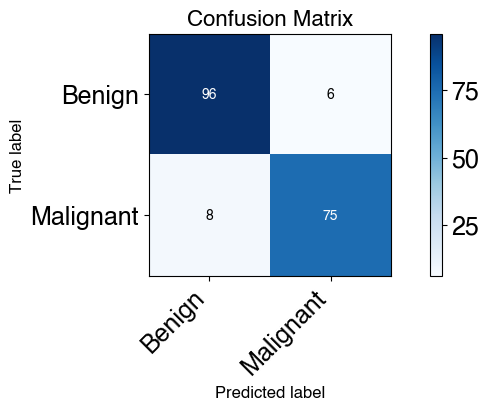

Saved ROC curve to ./figures/p1/test_balanced_roc_curve.png


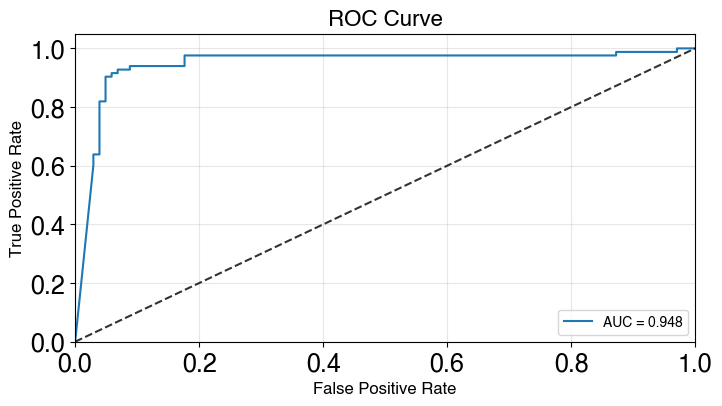

Saved precision-recall curve to ./figures/p1/test_balanced_precision_recall_curve.png


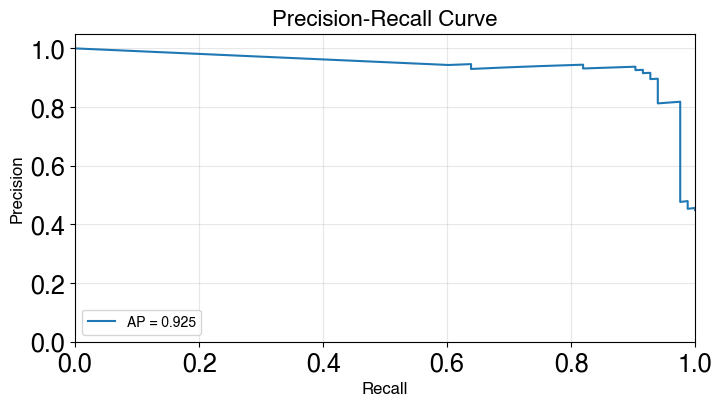


Model Evaluation Metrics:
Confusion Matrix:
[[96  6]
 [ 8 75]]
Accuracy: 0.9243
Precision: 0.9259
Recall: 0.9036
F1 Score: 0.9146
AUC-ROC: 0.9483
AUC-PR: 0.9247


In [34]:
X_final_test, y_final_test = cell_diagnosis_balanced_test.drop(columns=["Diagnosis"]), cell_diagnosis_balanced_test["Diagnosis"]

X_final_test = DataLoader.encode_categorical(X_final_test)
X_final_test, y_final_test = X_final_test.to_numpy(), y_final_test.to_numpy()

results = evaluate_model(
    model=final_model, 
    X_test=X_final_test, 
    y_test=y_final_test, 
    class_names=["Benign", "Malignant"],
    save_dir=fig_output_dir_p1, 
    base_filename="test_balanced"
)



## Desbalanceado

In [35]:
loader_cell_diagnosis_imbalanced = DataLoader(config_cell_diagnosis)

loader_cell_diagnosis_imbalanced.load_data(
    dev_file="raw/cell_diagnosis_imbalanced_dev.csv",
    test_file='raw/cell_diagnosis_imbalanced_test.csv',
    splitted=False
)

cell_diagnosis_imbalanced_dev_outliers, cell_diagnosis_imbalanced_test_outliers = loader_cell_diagnosis_imbalanced.get_pandas_data(splitted=False)


In [36]:
null_counts = cell_diagnosis_imbalanced_dev_outliers.isnull().sum()
print(null_counts)

total_rows = len(cell_diagnosis_imbalanced_dev_outliers)
null_percentage = (null_counts / total_rows) * 100

print("\nPorcentaje de valores nulos por columna:")
for col, pct in null_percentage.items():
    if pct > 0: 
        print(f"{col}: {pct:.2f}%")

# Contar muestras con al menos un valor nulo
samples_with_nulls = cell_diagnosis_imbalanced_dev_outliers.isnull().any(axis=1).sum()
samples_percentage = (samples_with_nulls / total_rows) * 100


# Contar muestras con al menos un valor nulo
samples_with_nulls = cell_diagnosis_imbalanced_dev_outliers.isnull().any(axis=1).sum()
samples_percentage = (samples_with_nulls / total_rows) * 100

print(f"\nMuestras con al menos un valor nulo: {samples_with_nulls} de {total_rows} ({samples_percentage:.2f}%)")

# cantidad de muestras sin nan
samples_without_nulls = total_rows - samples_with_nulls

print(f"Cantidad de muestras sin nan: {samples_without_nulls}")





CellSize               236
CellShape              237
NucleusDensity         220
ChromatinTexture       212
CytoplasmSize          245
CellAdhesion           214
MitosisRate            240
NuclearMembrane        225
GrowthFactor           230
OxygenSaturation       220
Vascularization        230
InflammationMarkers    219
Diagnosis                0
CellType               184
GeneticMutation          0
dtype: int64

Porcentaje de valores nulos por columna:
CellSize: 19.38%
CellShape: 19.46%
NucleusDensity: 18.06%
ChromatinTexture: 17.41%
CytoplasmSize: 20.11%
CellAdhesion: 17.57%
MitosisRate: 19.70%
NuclearMembrane: 18.47%
GrowthFactor: 18.88%
OxygenSaturation: 18.06%
Vascularization: 18.88%
InflammationMarkers: 17.98%
CellType: 15.11%

Muestras con al menos un valor nulo: 1126 de 1218 (92.45%)
Cantidad de muestras sin nan: 92


In [37]:
custom_cell_diagnosis_imbalanced_imputer = KNNImputer(n_neighbors=8, weights='distance',return_df=True)

Si ya se realizó el preprocesamiento, comentar el siguiente codigo

In [38]:

# # Primero ajustamos el imputador usando los datos de desarrollo
# custom_cell_diagnosis_imbalanced_imputer.fit(cell_diagnosis_imbalanced_dev_outliers)

# # Luego transformamos tanto los datos de desarrollo como los de test usando el mismo imputador
# cell_diagnosis_imbalanced_dev_outliers = custom_cell_diagnosis_imbalanced_imputer.transform(cell_diagnosis_imbalanced_dev_outliers)
# cell_diagnosis_imbalanced_test_outliers = custom_cell_diagnosis_imbalanced_imputer.transform(cell_diagnosis_imbalanced_test_outliers)

# ########################################################
# loader_cell_diagnosis_imbalanced.update(df_dev=cell_diagnosis_imbalanced_dev_outliers, df_test=cell_diagnosis_imbalanced_test_outliers)

# df_preprocessed_cell_diagnosis_imbalanced_dev_dir = data_dir / "p1" / "preprocessed" / "cell_diagnosis_imbalanced_dev.csv"
# df_preprocessed_cell_diagnosis_imbalanced_test_dir = data_dir / "p1" / "preprocessed" / "cell_diagnosis_imbalanced_test.csv"

# loader_cell_diagnosis_imbalanced.save_processed_data(df_dev_dir=df_preprocessed_cell_diagnosis_imbalanced_dev_dir, df_test_dir=df_preprocessed_cell_diagnosis_imbalanced_test_dir)

In [39]:
loader_cell_diagnosis_imbalanced.load_data(
    dev_file="preprocessed/cell_diagnosis_imbalanced_dev.csv",
    test_file='preprocessed/cell_diagnosis_imbalanced_test.csv'
)

cell_diagnosis_imbalanced_dev_outliers, cell_diagnosis_imbalanced_test_outliers = loader_cell_diagnosis_imbalanced.get_pandas_data()


ValueError: train_file must be provided when splitted=True

Saved figure to ./figures/p1/correlation_heatmap_numerical_features_imbalanced_outliers.png


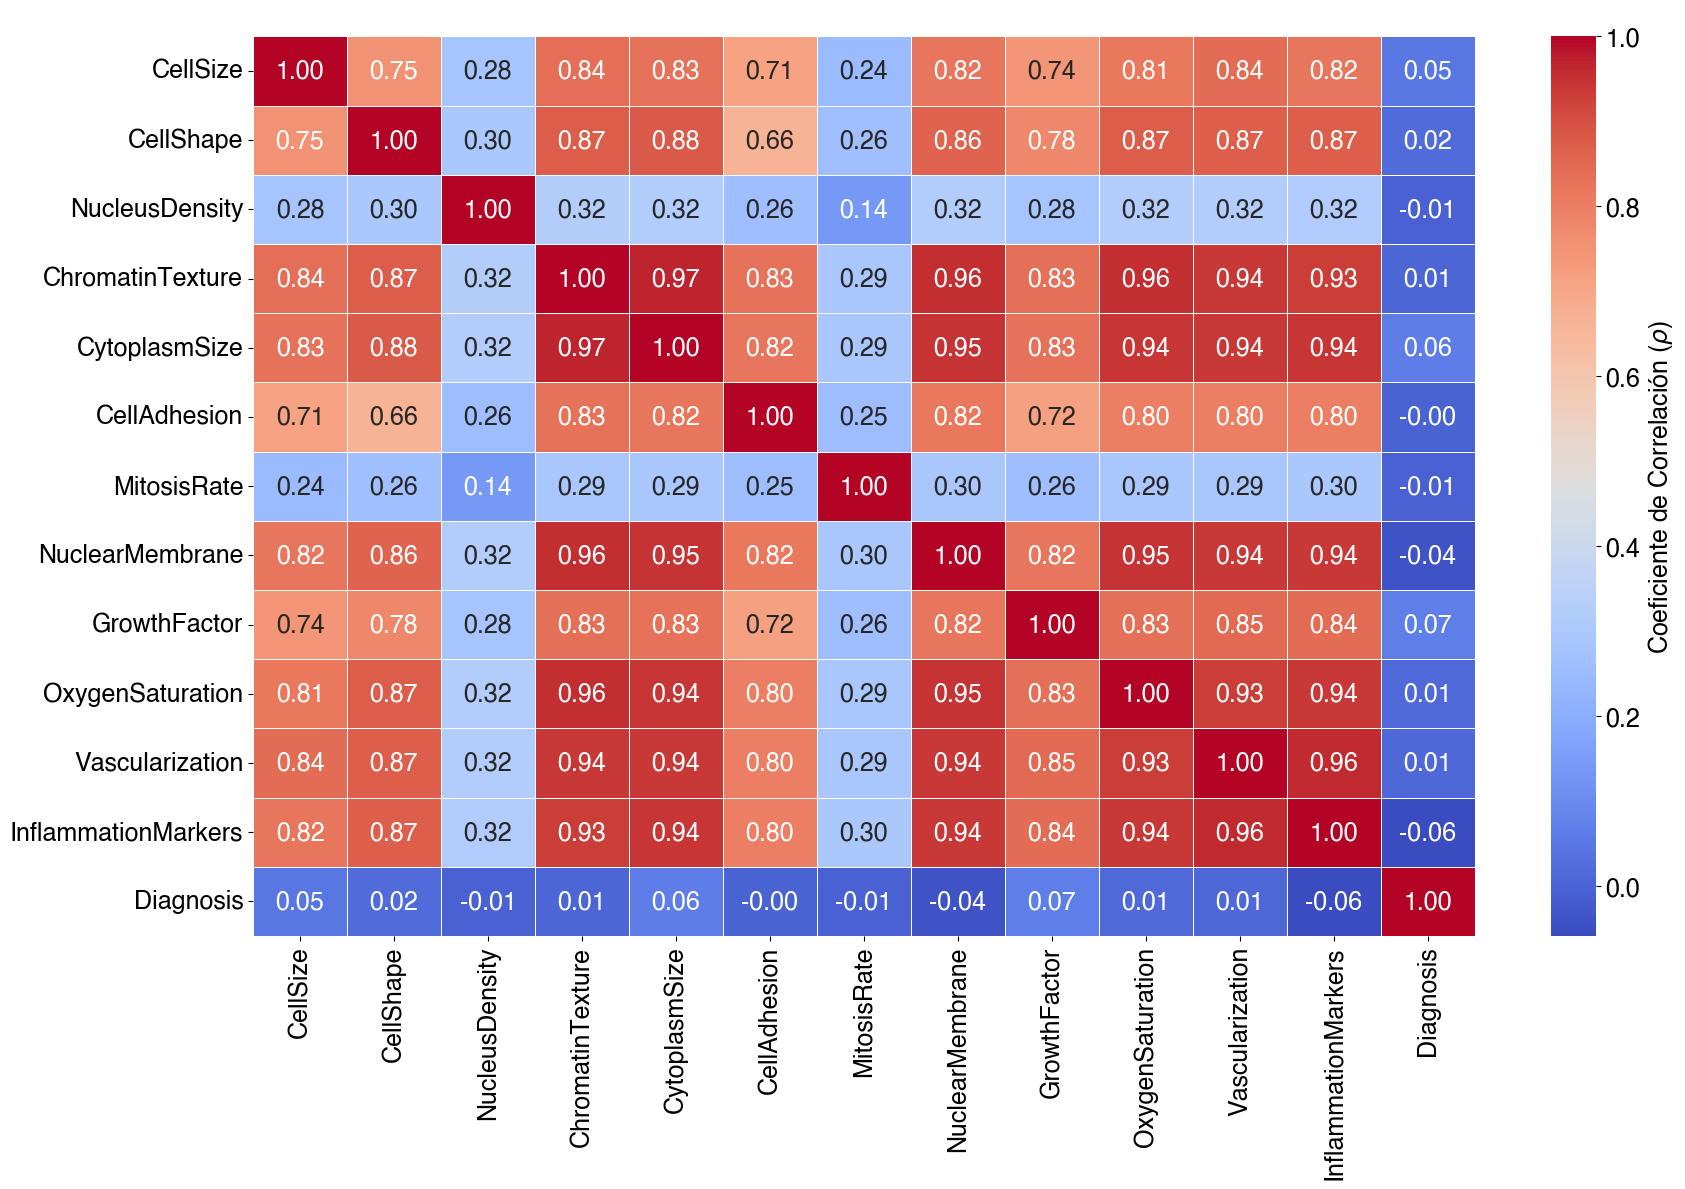

Gráfico guardado en: ./figures/p1/boxplots_analysis_imbalanced_outliers.png


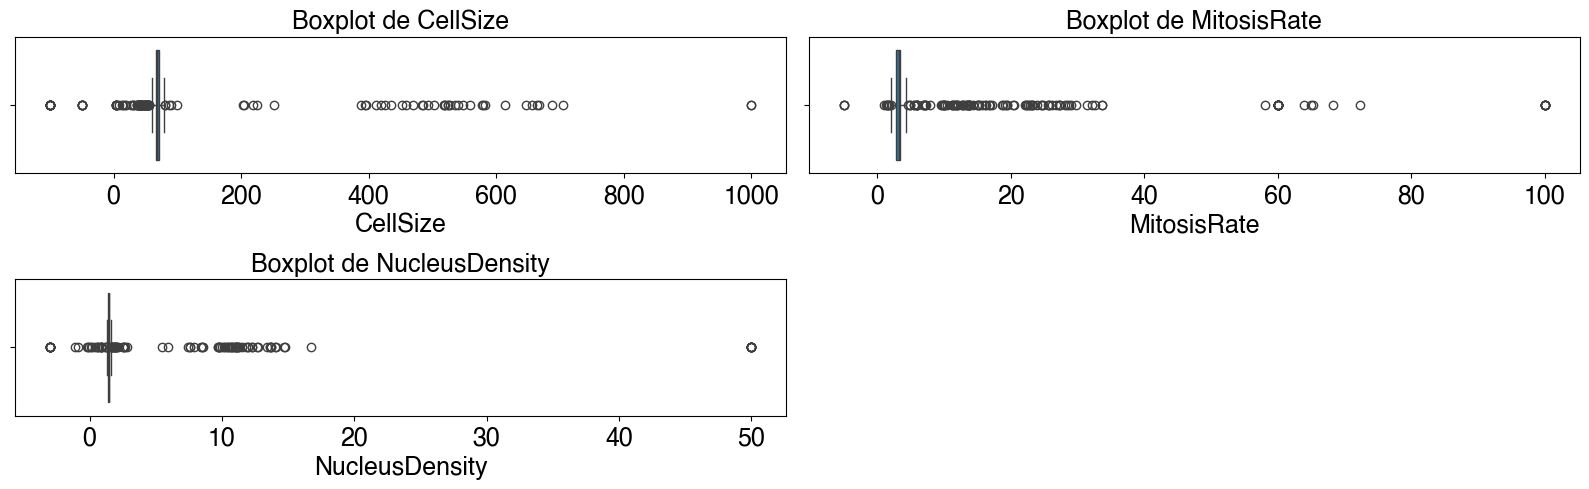

In [ ]:

fig = plot_correlation_heatmap(
    cell_diagnosis_imbalanced_dev_outliers, 
    numerical_cols + ["Diagnosis"],
    output_dir=fig_output_dir_p1,
    filename="correlation_heatmap_numerical_features_imbalanced_outliers.png",
    title=' ',
    label_fontsize=18,
    title_fontsize=18,
    tick_fontsize=18,
    cbar_fontsize=18,
    annot_fontsize=18,
    figsize=(18,12),
)
plt.show()


from utils.visuals import plot_outliers_analysis


fig = plot_outliers_analysis(
    df=cell_diagnosis_imbalanced_dev_outliers, 
    features_to_plot=FEATURES_TO_PLOT,
    save_dir=fig_output_dir_p1,
    figsize=(16, 5),
    filename='boxplots_analysis_imbalanced_outliers.png',
    show_plots=True
)


In [ ]:

cell_diagnosis_imbalanced_dev = replace_outliers_iqr(cell_diagnosis_imbalanced_dev_outliers, method='winsorize')
cell_diagnosis_imbalanced_test = replace_outliers_iqr(cell_diagnosis_imbalanced_test_outliers, method='winsorize')

loader_cell_diagnosis.update(df_dev=cell_diagnosis_balanced_dev, df_test=cell_diagnosis_balanced_test)

df_cell_diagnosis_dev_dir = data_dir / "p1" / "processed" / "cell_diagnosis_imbalanced_dev.csv"
df_cell_diagnosis_test_dir = data_dir / "p1" / "processed" / "cell_diagnosis_imbalanced_test.csv"

loader_cell_diagnosis.save_processed_data(df_dev_dir=df_cell_diagnosis_dev_dir, df_test_dir=df_cell_diagnosis_test_dir)


loader_cell_diagnosis.load_data(
    dev_file="processed/cell_diagnosis_imbalanced_dev.csv",
    test_file='processed/cell_diagnosis_imbalanced_test.csv'
)

cell_diagnosis_imbalanced_dev, cell_diagnosis_imbalanced_test = loader_cell_diagnosis.get_pandas_data()


print_numerical_features_range(cell_diagnosis_imbalanced_dev)



Development data saved to /Users/juanfra/Documents/Facultad/3er año - 1er Cuatri/Aprendizaje Automatico/TPs/tp2-machine-learning /data/p1/processed/cell_diagnosis_imbalanced_dev.csv
Test data saved to /Users/juanfra/Documents/Facultad/3er año - 1er Cuatri/Aprendizaje Automatico/TPs/tp2-machine-learning /data/p1/processed/cell_diagnosis_imbalanced_test.csv
Rango de cada feature numérica (13 features):
CellSize: [57.8066, 81.2770]
CellShape: [0.4300, 0.5715]
NucleusDensity: [1.2654, 1.6194]
ChromatinTexture: [19.3286, 24.7755]
CytoplasmSize: [20.5028, 36.3534]
CellAdhesion: [0.4114, 0.5401]
MitosisRate: [1.8396, 4.3824]
NuclearMembrane: [1.8425, 2.9422]
GrowthFactor: [50.4411, 70.4532]
OxygenSaturation: [76.6172, 83.6087]
Vascularization: [4.1236, 5.9858]
InflammationMarkers: [27.8317, 53.5267]
Diagnosis: [0.0000, 1.0000]


In [88]:


loader_cell_diagnosis.load_data(
    dev_file="processed/cell_diagnosis_imbalanced_dev.csv",
    test_file='processed/cell_diagnosis_imbalanced_test.csv'
)

cell_diagnosis_imbalanced_dev, cell_diagnosis_imbalanced_test = loader_cell_diagnosis.get_pandas_data()


print_numerical_features_range(cell_diagnosis_imbalanced_dev)



Rango de cada feature numérica (13 features):
CellSize: [57.8066, 81.2770]
CellShape: [0.4300, 0.5715]
NucleusDensity: [1.2654, 1.6194]
ChromatinTexture: [19.3286, 24.7755]
CytoplasmSize: [20.5028, 36.3534]
CellAdhesion: [0.4114, 0.5401]
MitosisRate: [1.8396, 4.3824]
NuclearMembrane: [1.8425, 2.9422]
GrowthFactor: [50.4411, 70.4532]
OxygenSaturation: [76.6172, 83.6087]
Vascularization: [4.1236, 5.9858]
InflammationMarkers: [27.8317, 53.5267]
Diagnosis: [0.0000, 1.0000]


Saved figure to ./figures/p1/correlation_heatmap_numerical_features_imbalanced.png


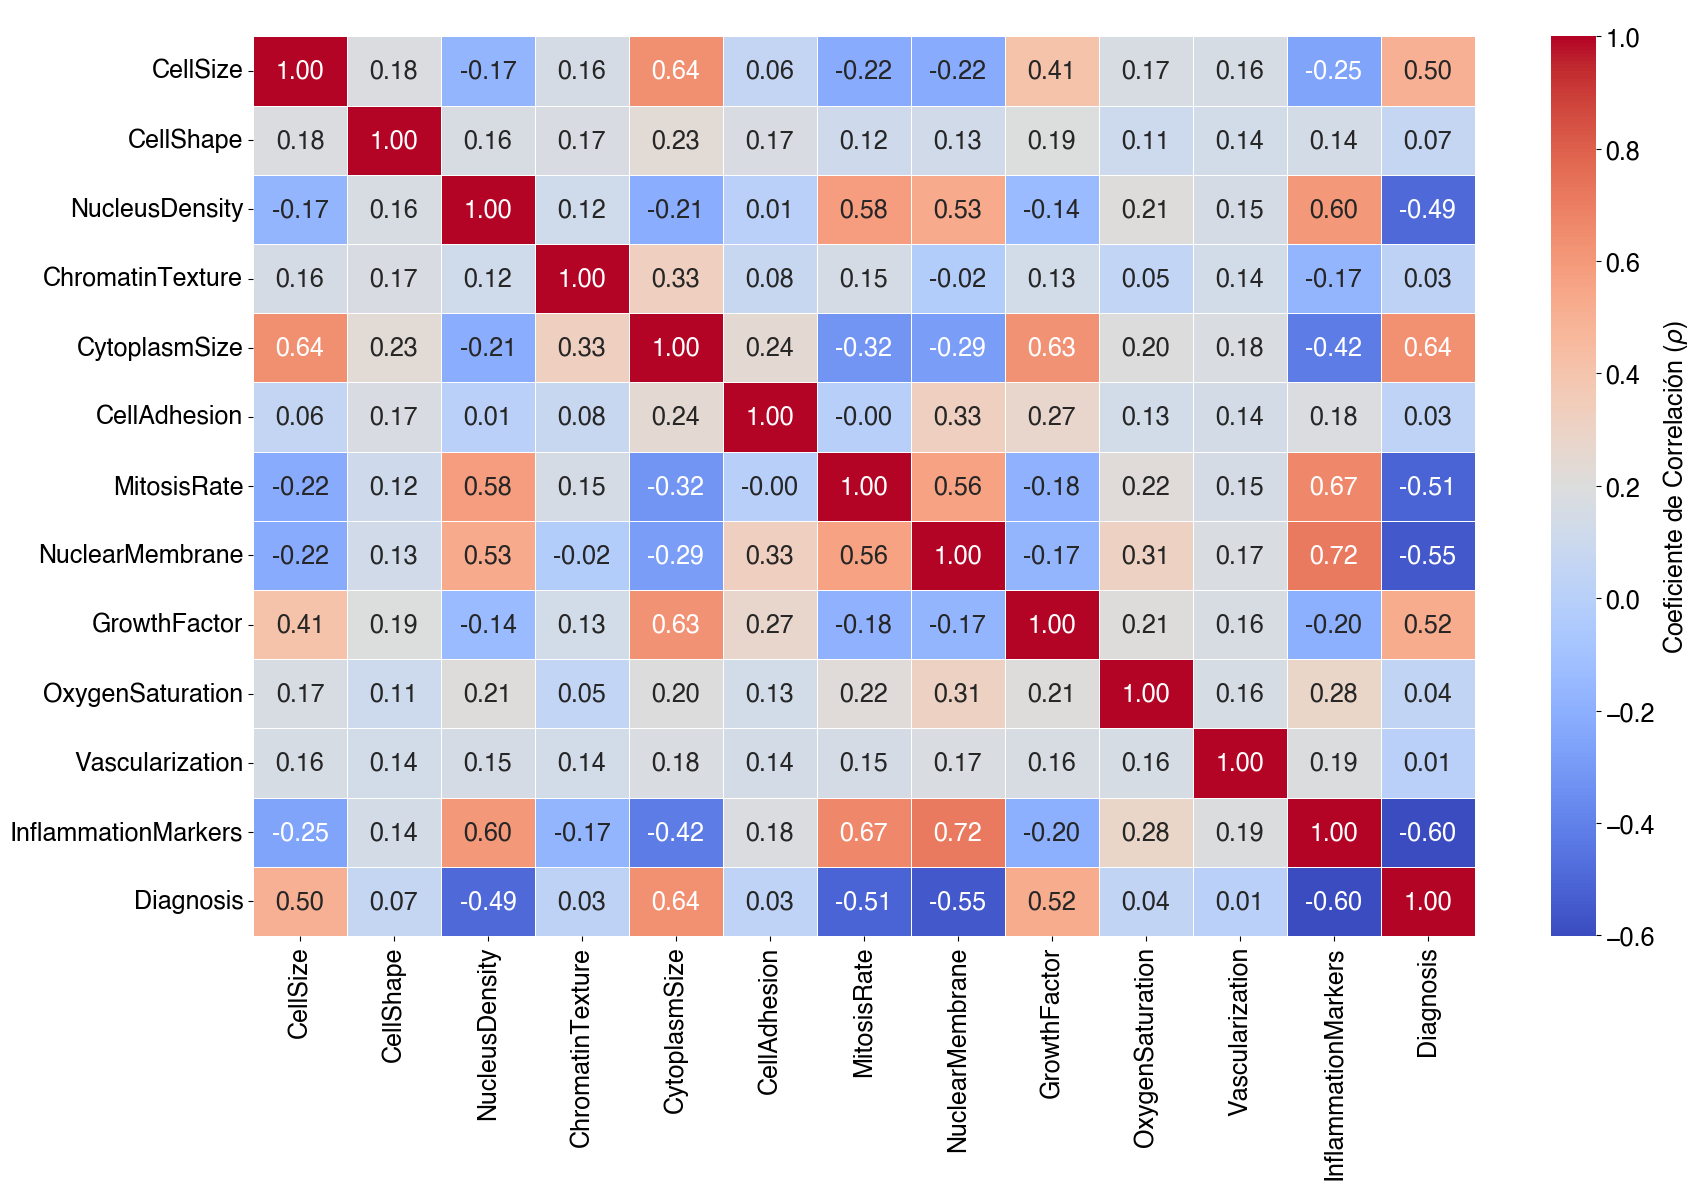

Gráfico guardado en: ./figures/p1/boxplots_analysis_imbalanced.png


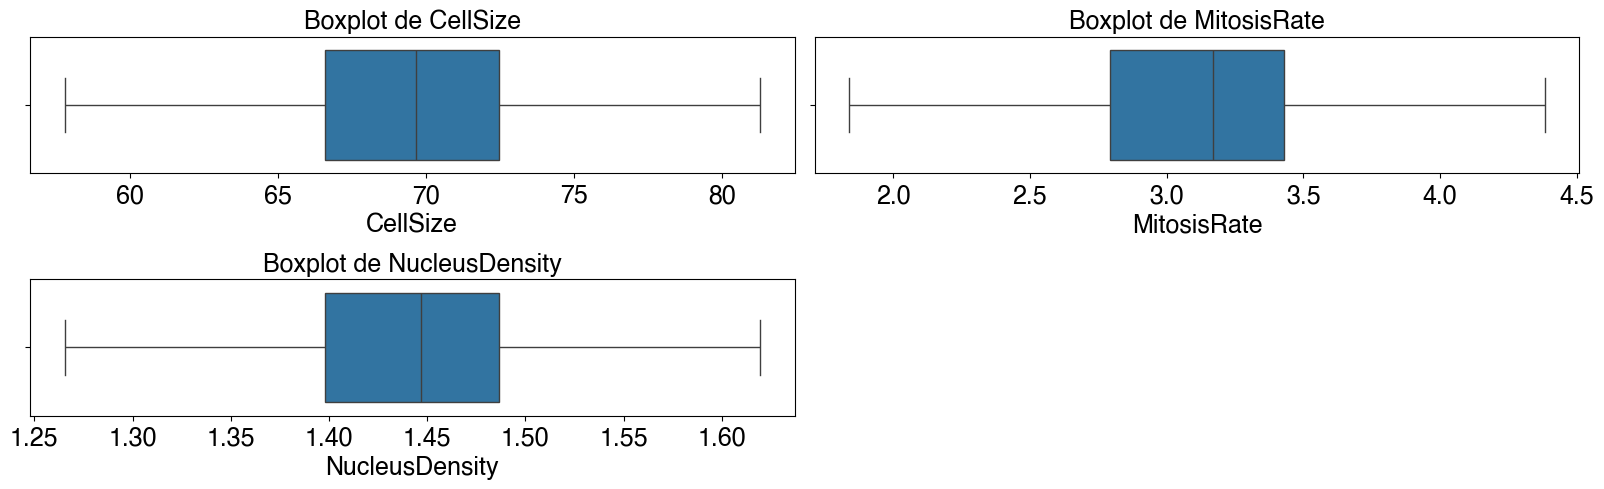

In [ ]:

fig = plot_correlation_heatmap(
    cell_diagnosis_imbalanced_dev, 
    numerical_cols + ["Diagnosis"],
    output_dir=fig_output_dir_p1,
    filename="correlation_heatmap_numerical_features_imbalanced.png",
    title=' ',
    label_fontsize=18,
    title_fontsize=18,
    tick_fontsize=18,
    cbar_fontsize=18,
    annot_fontsize=18,
    figsize=(18,12),
)
plt.show()


from utils.visuals import plot_outliers_analysis


fig = plot_outliers_analysis(
    df=cell_diagnosis_imbalanced_dev, 
    features_to_plot=FEATURES_TO_PLOT,
    save_dir=fig_output_dir_p1,
    figsize=(16, 5),
    filename='boxplots_analysis_imbalanced.png',
    show_plots=True
)


## Punto 1.4 y 1.5

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from models.logistic_regression import LogisticRegression, LogisticRegressionConfig
from models.logistic_regression_with_cost import CostSensitiveLogisticRegression, CostSensitiveLogisticRegressionConfig
from preprocessing.data_loader import DataLoader, DatasetConfig, SplitConfig
from preprocessing.rebalancing import (
    RandomUnderSampler, 
    RandomOverSampler, 
    SMOTE, 
    SMOTEConfig,
    RebalancingConfig
)
from utils.utils import evaluate_model
from utils.visuals import plot_roc_curve, plot_precision_recall_curve


def calculate_class_weights(y):
    classes, counts = np.unique(y, return_counts=True)
    total = len(y)
    
    # Calculate class probabilities
    probs = counts / total
    
    # Find majority class and its probability
    majority_idx = np.argmax(counts)
    majority_class = classes[majority_idx]
    majority_prob = probs[majority_idx]
    
    # Initialize weights with 1 for all classes
    weights = {cls: 1.0 for cls in classes}
    
    # Apply weight C = π2/π1 only to minority classes
    for i, cls in enumerate(classes):
        if cls != majority_class:  # If it's a minority class
            weights[cls] = majority_prob / probs[i]
    
    return weights


# Configuración de directorios
fig_output_dir_p1 = "./figures/p1"
os.makedirs(fig_output_dir_p1, exist_ok=True)
current_dir = Path.cwd()
data_dir = current_dir.parent / "data"
data_dir = data_dir.resolve() 

# Configuración del dataset
dataset_config = DatasetConfig(
    data_dir=data_dir,
    target_column="Diagnosis",
    split_config=SplitConfig(test_size=0.2, shuffle=True, random_state=42)
)

# Parámetros de entrenamiento
lambda_reg = 0.1
lr_config = LogisticRegressionConfig(
    learning_rate=0.01,
    max_iter=1000,
    tol=1e-4,
    lambda_reg=lambda_reg,
    random_state=42,
    verbose=True
)

# Carga de datos
df_train, df_test = cell_diagnosis_imbalanced_dev, cell_diagnosis_imbalanced_test
print(f"Development data shape: {df_train.shape}")
print(f"Test data shape: {df_test.shape}")

# Estadísticas del dataset
print("\nClass distribution in development data:")
class_counts = df_train[dataset_config.target_column].value_counts()
print(class_counts)
print(f"Class imbalance ratio: {class_counts.max() / class_counts.min():.2f}")

# Preprocesamiento de datos
X_train, X_val, y_train, y_val = loader_cell_diagnosis.train_test_split(
    return_splitted=True, 
    return_numpy=True, 
    encode_categorical=True,
    normalize=True
)

X_test, y_test = loader_cell_diagnosis.get_processed_test_data(
    return_numpy=True,
    encode_categorical=True,
    normalize=True
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Nombre de las clases para las métricas
class_names = ["Benign", "Malignant"]

# Diccionario para almacenar modelos y métricas
all_models = {}

# 1. Sin rebalanceo (baseline)
print("\n===== Training model without rebalancing =====")
model_no_rebalancing = LogisticRegression(lr_config)
model_no_rebalancing.fit(X_train, y_train)

metrics_no_rebalancing = evaluate_model(
    model_no_rebalancing, X_val, y_val, 
    class_names=class_names, show_plots=False,
    threshold=0.5, figsize=(10, 6), print_metrics=False
)

all_models["No rebalancing"] = {
    "model": model_no_rebalancing,
    "metrics": metrics_no_rebalancing
}

# 2. Undersampling
print("\n===== Training model with Undersampling =====")
undersampler = RandomUnderSampler(RebalancingConfig(random_state=42))
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

# Estadísticas después del rebalanceo
unique, counts = np.unique(y_train_under, return_counts=True)
print("Class distribution after undersampling:")
for cls, count in zip(unique, counts):
    print(f"Class {cls}: {count} samples")

model_undersampling = LogisticRegression(lr_config)
model_undersampling.fit(X_train_under, y_train_under)

metrics_undersampling = evaluate_model(
    model_undersampling, X_val, y_val, 
    class_names=class_names, show_plots=False,
    threshold=0.5, figsize=(10, 6), print_metrics=False
)

all_models["Undersampling"] = {
    "model": model_undersampling,
    "metrics": metrics_undersampling
}

# 3. Oversampling via duplication
print("\n===== Training model with Oversampling (duplication) =====")
oversampler = RandomOverSampler(RebalancingConfig(random_state=42))
X_train_over, y_train_over = oversampler.fit_resample(X_train, y_train)

# Estadísticas después del rebalanceo
unique, counts = np.unique(y_train_over, return_counts=True)
print("Class distribution after oversampling:")
for cls, count in zip(unique, counts):
    print(f"Class {cls}: {count} samples")

model_oversampling = LogisticRegression(lr_config)
model_oversampling.fit(X_train_over, y_train_over)

metrics_oversampling = evaluate_model(
    model_oversampling, X_val, y_val, 
    class_names=class_names, show_plots=False,
    threshold=0.5, figsize=(10, 6), print_metrics=False
)

all_models["Oversampling duplicate"] = {
    "model": model_oversampling,
    "metrics": metrics_oversampling
}

# 4. Oversampling via SMOTE
print("\n===== Training model with SMOTE =====")
smote = SMOTE(SMOTEConfig(random_state=42, k_neighbors=5))
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Estadísticas después del rebalanceo
unique, counts = np.unique(y_train_smote, return_counts=True)
print("Class distribution after SMOTE:")
for cls, count in zip(unique, counts):
    print(f"Class {cls}: {count} samples")

model_smote = LogisticRegression(lr_config)
model_smote.fit(X_train_smote, y_train_smote)

metrics_smote = evaluate_model(
    model_smote, X_val, y_val, 
    class_names=class_names, show_plots=False,
    threshold=0.5, figsize=(10, 6), print_metrics=False
)

all_models["Oversampling SMOTE"] = {
    "model": model_smote,
    "metrics": metrics_smote
}

# 5. Cost reweighting
print("\n===== Training model with Cost reweighting =====")
class_weights = calculate_class_weights(y_train)
print(f"Class weights: {class_weights}")

cost_config = CostSensitiveLogisticRegressionConfig(
    learning_rate=0.01,
    max_iter=1000,
    tol=1e-4,
    lambda_reg=lambda_reg,
    random_state=42,
    verbose=True,
    class_weight=class_weights
)

model_cost = CostSensitiveLogisticRegression(cost_config)
model_cost.fit(X_train, y_train)

metrics_cost = evaluate_model(
    model_cost, X_val, y_val, 
    class_names=class_names, show_plots=False,
    threshold=0.5, figsize=(10, 6), print_metrics=False
)

all_models["Cost re-weighting"] = {
    "model": model_cost,
    "metrics": metrics_cost
}

Development data shape: (1663, 15)
Test data shape: (185, 15)

Class distribution in development data:
Diagnosis
0.0    914
1.0    749
Name: count, dtype: int64
Class imbalance ratio: 1.22

Training set: 1331 samples
Validation set: 332 samples
Test set: 185 samples

===== Training model without rebalancing =====
Iteration 0, Cost: 0.694570
Iteration 100, Cost: 0.424808
Iteration 200, Cost: 0.343257
Iteration 300, Cost: 0.306654
Iteration 400, Cost: 0.286470
Iteration 500, Cost: 0.273895
Converged at iteration 505 with cost 0.273392

===== Training model with Undersampling =====
Class distribution after undersampling:
Class 0.0: 716 samples
Class 1.0: 615 samples
Iteration 0, Cost: 0.694570
Iteration 100, Cost: 0.424808
Iteration 200, Cost: 0.343257
Iteration 300, Cost: 0.306654
Iteration 400, Cost: 0.286470
Iteration 500, Cost: 0.273895
Converged at iteration 505 with cost 0.273392

===== Training model with Oversampling (duplication) =====
Class distribution after oversampling:
Class

In [91]:
from utils.visuals import plot_comparative_curves


Evaluating No rebalancing on validation set
Evaluating Undersampling on validation set
Evaluating Oversampling duplicate on validation set
Evaluating Oversampling SMOTE on validation set
Evaluating Cost re-weighting on validation set


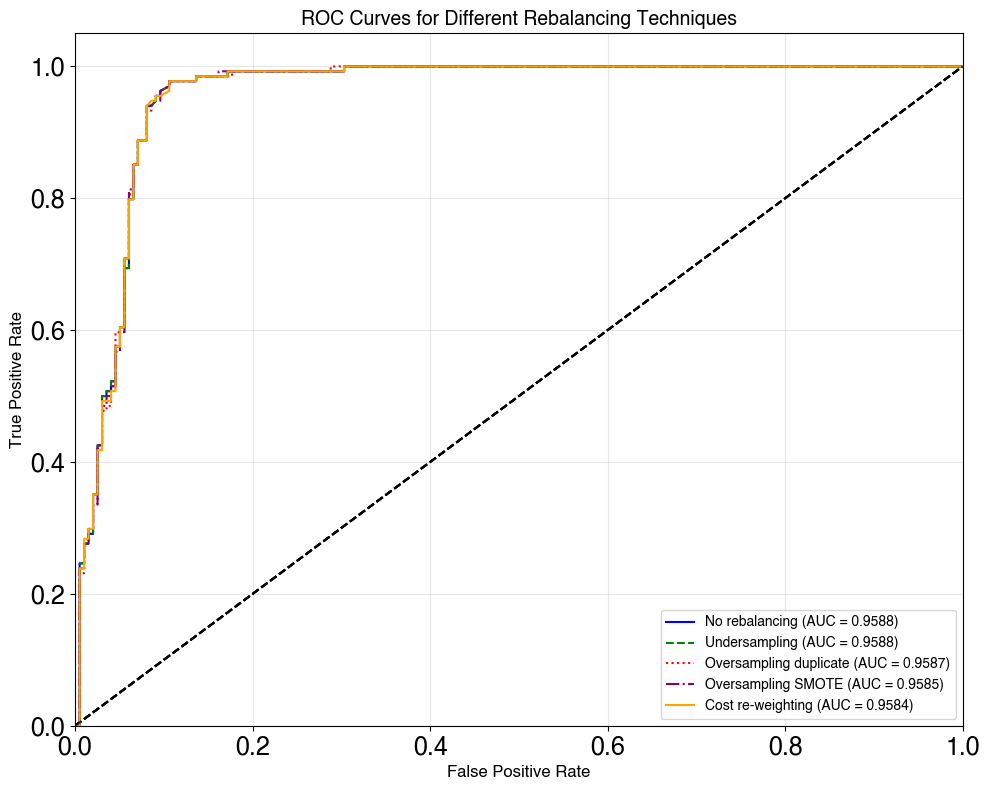

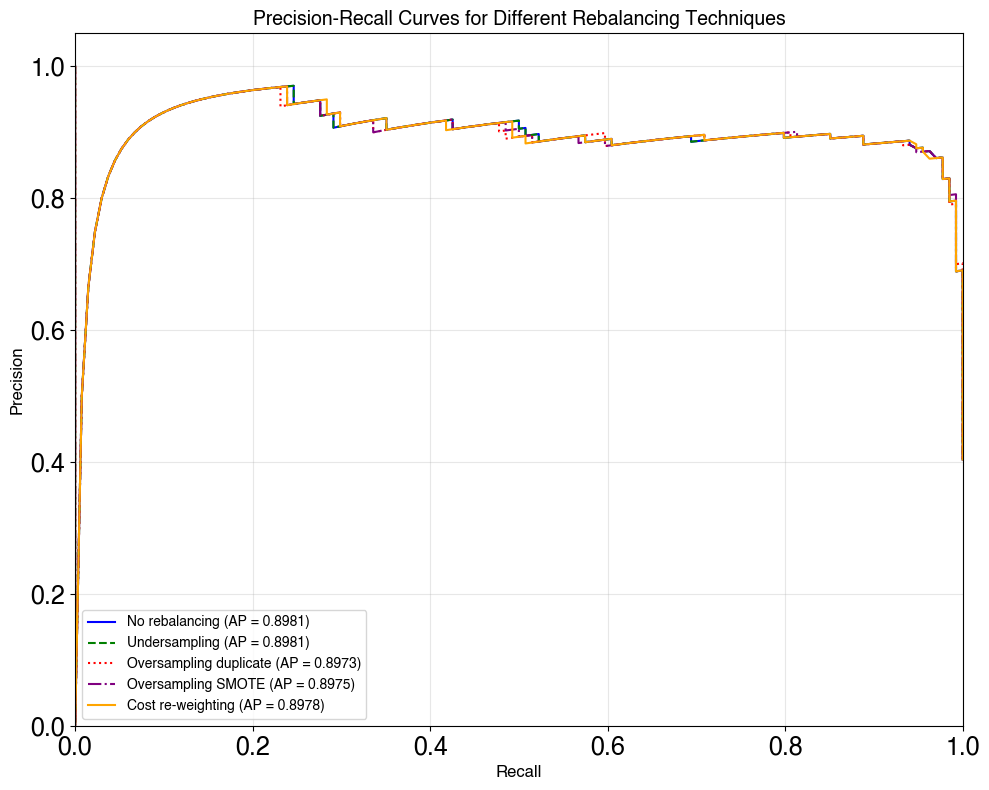

Evaluating No rebalancing on test set
Evaluating Undersampling on test set
Evaluating Oversampling duplicate on test set
Evaluating Oversampling SMOTE on test set
Evaluating Cost re-weighting on test set


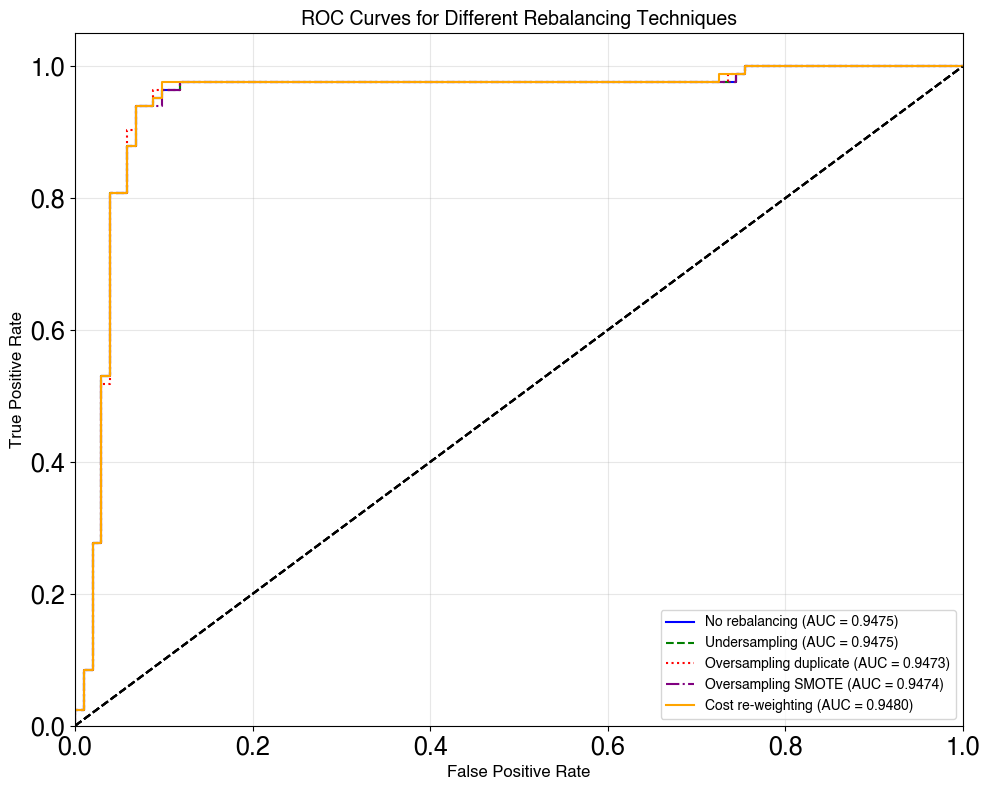

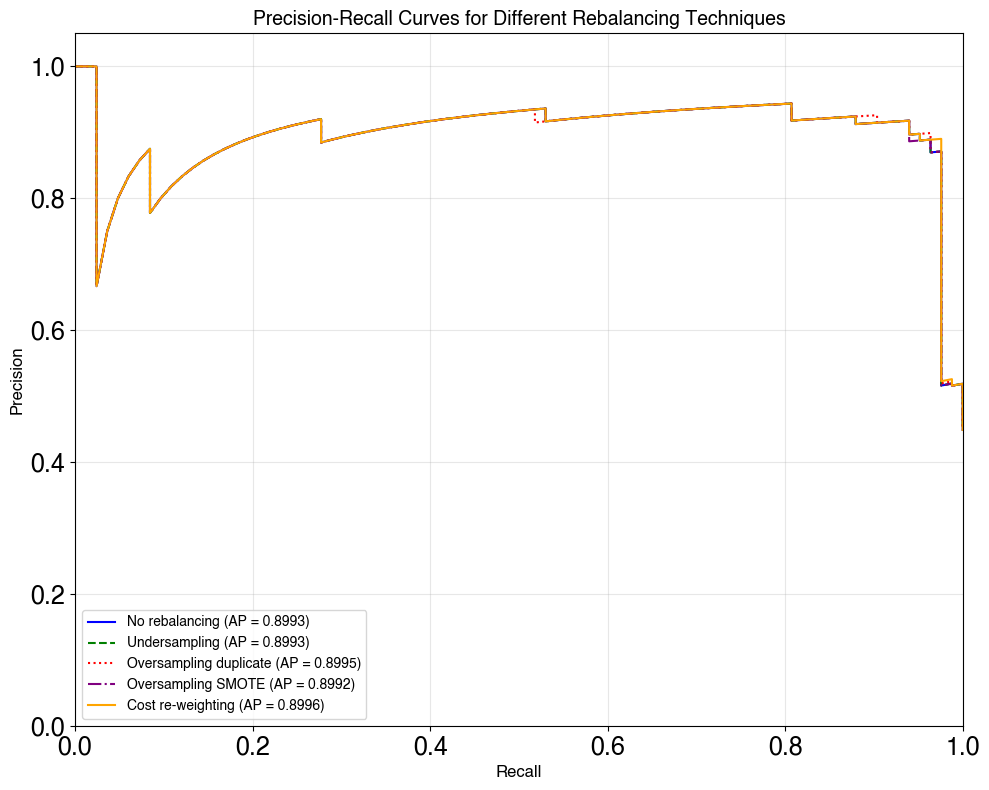


===== Validation Metrics Summary =====
                 Model Accuracy Precision Recall F-Score AUC-ROC AUC-PR
        No rebalancing   0.9157    0.8841 0.9104  0.8971  0.9588 0.8981
         Undersampling   0.9157    0.8841 0.9104  0.8971  0.9588 0.8981
Oversampling duplicate   0.9217    0.8857 0.9254  0.9051  0.9587 0.8973
    Oversampling SMOTE   0.9247    0.8865 0.9328  0.9091  0.9585 0.8975
     Cost re-weighting   0.9247    0.8865 0.9328  0.9091  0.9584 0.8978

===== Test Metrics Summary =====
                 Model Accuracy Precision Recall F-Score AUC-ROC AUC-PR
        No rebalancing   0.9189    0.9146 0.9036  0.9091  0.9475 0.8993
         Undersampling   0.9189    0.9146 0.9036  0.9091  0.9475 0.8993
Oversampling duplicate   0.9243    0.9157 0.9157  0.9157  0.9473 0.8995
    Oversampling SMOTE   0.9189    0.9146 0.9036  0.9091  0.9474 0.8992
     Cost re-weighting   0.9243    0.9157 0.9157  0.9157  0.9480 0.8996


In [ ]:
from utils.utils import evaluate_all_models


# Evaluar en conjunto de validación
val_metrics_df, val_metrics = evaluate_all_models(
    all_models, 
    X_val, 
    y_val, 
    class_names, 
    fig_output_dir_p1,
    prefix="validation",
    show_plot=True,
    individual_plots=False
)

# Evaluar en conjunto de prueba
test_metrics_df, test_metrics = evaluate_all_models(
    all_models, 
    X_test, 
    y_test, 
    class_names, 
    fig_output_dir_p1,
    prefix="test",
    show_plot=True,
    individual_plots=False
)


print("\n===== Validation Metrics Summary =====")
print(val_metrics_df.to_string(index=False))

print("\n===== Test Metrics Summary =====")
print(test_metrics_df.to_string(index=False))